# Orion Tulog

This is a tutorial for anomaly detection using Orion. Orion is a `python` package for time series anoamly detection. It provides a suite of both statistical and machine learning models that enable efficient anomaly detection.

In this tutorial, we will learn how to set up Orion, train a machine learning model, and perform anomaly detection. We will delve into each part seperately and then run the evaluation pipeline from beginning to end in order to compare multiple models against each other.

In [1]:
# general imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

## Part 1
In part one of the series, we explore a time series data, particularly the NYC taxi data. You can find the raw data on the [TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) or the processed version maintained by Numenta [here](https://github.com/numenta/NAB/tree/master/data). We also explore what reasons could possibily be contributing to producing such anomalies.

### Data Loading
There is a collection of data already available in Orion, to load them, we use the `load_signal` function and pass the name of the signal we wish to obtain. Similarly, since this data is labeled, we use the `load_anomalies` function to get the corresponding anomaly of the signal

In [2]:
from orion.data import load_signal, load_anomalies

In [3]:
signal = 'nyc_taxi'

# load signal
df = load_signal(signal)

# load ground truth anomalies
known_anomalies = load_anomalies(signal)

df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


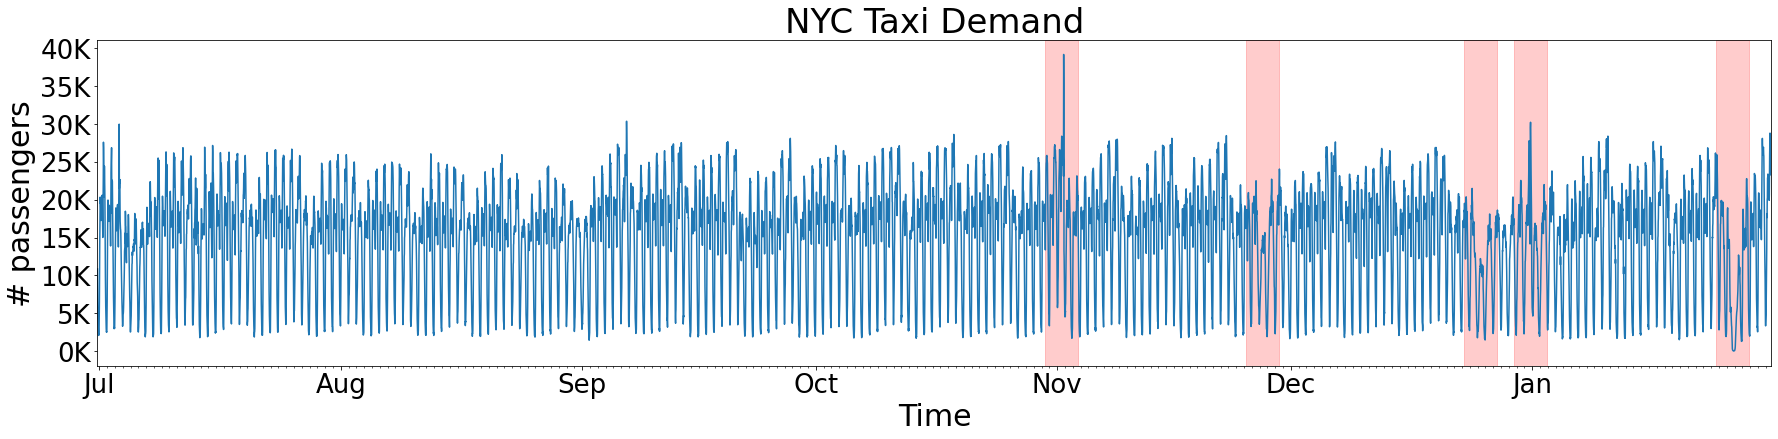

In [4]:
plot(df, known_anomalies)

---

## Part 2

In part two of the series, we look at anomaly detection through time series reconstruction, particularly using a GAN model. We go through a sequence of transformations and data preparation, as well as model training and prediction.

### Orion API
We will use `Orion` to perform these sequence of actions. We will be emphasizing the usage of the `TadGAN` model which is a time series anomaly detection using GANs model. The model is specified in a `json` format accompanied with this notebook named `tadgan.json`. There are more pipelines defined within the repository including: ARIMA, LSTM, etc. 

The Orion API is a simple interface that allows you to interact with anomaly detection pipeline. To train the model on the data, we simply use the `fit` method; to do anomaly detection, we use the `detect` method. In our case, we want to fit the data and then perform detection; therefore we use the `fit_detect` method. This might take some time to run. Once it’s done, we can visualize the results.

**Note**: the model might take some time to train. For experimentation purposes, you can reduce the number of `epochs` in the `tadgan.json` file such that you reduce the number of training iterations. 

In [5]:
from orion import Orion


orion = Orion(
    pipeline='tadgan.json'
)

anomalies = orion.fit_detect(df)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/5, [Dx loss: [-0.64890754 -3.1043665   1.6352817   0.08201778]] [Dz loss: [-4.3098288   0.078176   -5.804532    0.14165267]] [G loss: [12.476643   -1.6321402  12.493697    0.16150826]]
Epoch: 2/5, [Dx loss: [-1.0334046 -6.6927066  5.469194   0.0190108]] [Dz loss: [-49.170933     0.54461855 -52.600925     0.28853685]] [G loss: [69.64303    -5.4322224  73.65034     0.14249182]]
Epoch: 3/5, [Dx loss: [-1.0212965 -4.423846   3.195871   0.0206679]] [Dz loss: [-213.80779       2.1443276  -223.34793       0.73958045]] [G loss: [ 2.5739322e+02 -3.2226617e+00  2.5929694e+02  1.3189200e-01]]
Epoch: 4/5, [Dx loss: [ -0.7634776  -10.281804     9.380475     0.01378515]] [Dz loss: [-195.27487      3.4677377 -223.56815      2.4825501]] [G loss: [ 2.3684576e+02 -9.2494116e+00  2.4478499e+02  1.3102235e-01]]
Epoch: 5/5, [Dx loss: [ -1.1581926  -12.801564    11.489978     0.01533976]] [Dz loss: [ -4.2332234   4.1356316 -36.50674     2.8137882]] [G loss: [ 28.055197   -11.470886    38.031044    

Let's visualize the results.

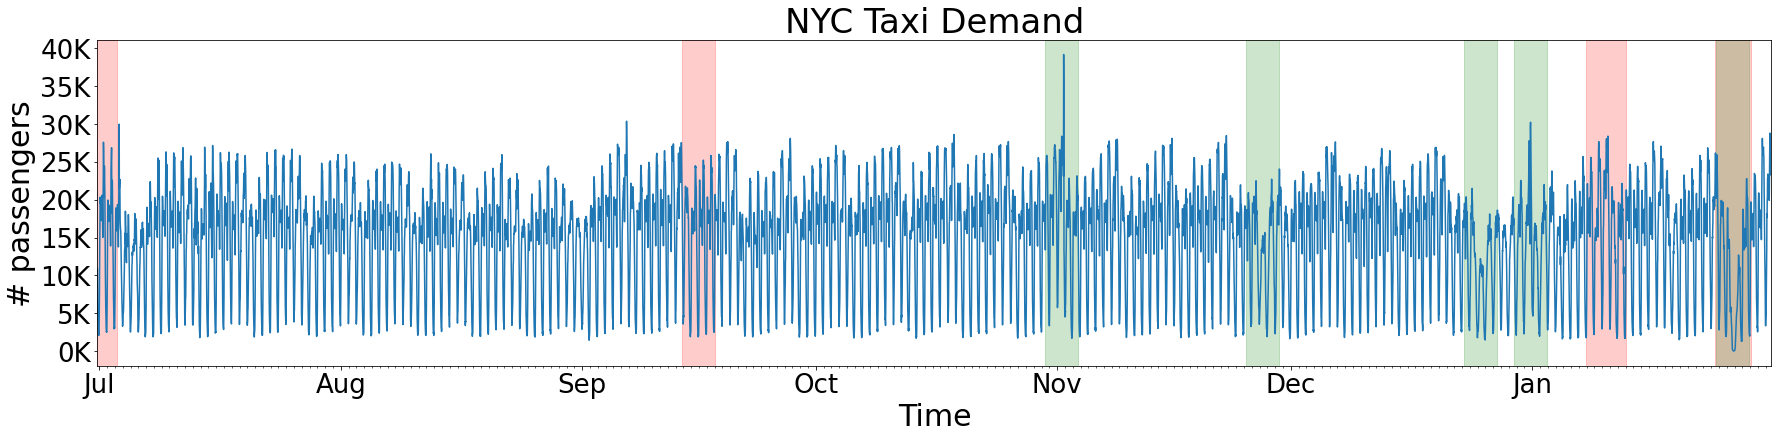

,start,end,severity
0,1404165600,1404379800,0.996046
1,1410651000,1411012800,0.312249
2,1420684200,1421132400,0.190520
3,1422118800,1422514800,0.991284


In [6]:
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

The red intervals depict the detected anomalies, the green intervals show the ground truth. Cool! the model was able to detect some anomalies. We also see that it detected some other intervals that were not included in the ground truth labels. It is clear though, they are falling out of shape with respect to the remaining signal.
_Note: the results might differ between runs._


We might have jumped straight to the results but let's trace back and look at what the model actually did.

There is a series of transformations happening to the data in order to obtain the result you have just seen. From data preprocessing, model training, to post-processing functionalities. We specify these functions, which we refer to as primitives, within the model’s `.json` file. What are these primitives? If we were to look at the `tadgan.json` model, we find these sequential primitives:

```
"primitives": [ 
    "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate”,
    "sklearn.impute.SimpleImputer",
    "sklearn.preprocessing.MinMaxScaler",
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences",
    "orion.primitives.tadgan.TadGAN",
    "orion.primitives.tadgan.score_anomalies",
    "orion.primitives.timeseries_anomalies.find_anomalies"
]
```

Each primitive is responsible for a single task. We describe the procedure of each primitive in the remainder of this notebook

### Data Preparation 
#### A. data frequency
Adjust signal spacing to be of equal width across all times. There are two important parameters in this process:
- interval: an interger that refers to the time span to compute aggregation of.
- method: what aggregation method should be used to compute the value, by default this set to the mean.

In addition to, passing the array of values and which column holds the values we wish to alter the frequency of.

In [7]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

If we go back to the source of the NYC Taxi data, we find that it records a value each 30 minutes. In the timestamp world, this is equivalent to 1800 seconds, therefore we set the interval to be `1800`. We also opt for the default aggregation method which is taking the `mean` value of each interval.

Technically speaking, in our example the data is perfectly spaced, so we can skip this preprocessing step. However, that is not always the case and so we include it as a preprocessing primitive in the general pipeline as you will see later on.

#### B. data imputation

impute missing values that appear within the signal using scikit-learn's `SimpleImputer` which fills missing values by the mean value.

In [8]:
imp = SimpleImputer()
X = imp.fit_transform(X)

#### C. data normalization 
normalize the data between a specific range, we use scikit-learn's `MinMaxScaler` to scale data between [-1, 1].

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

Notice how the y-axis changed after normalizing the data between [-1, 1]

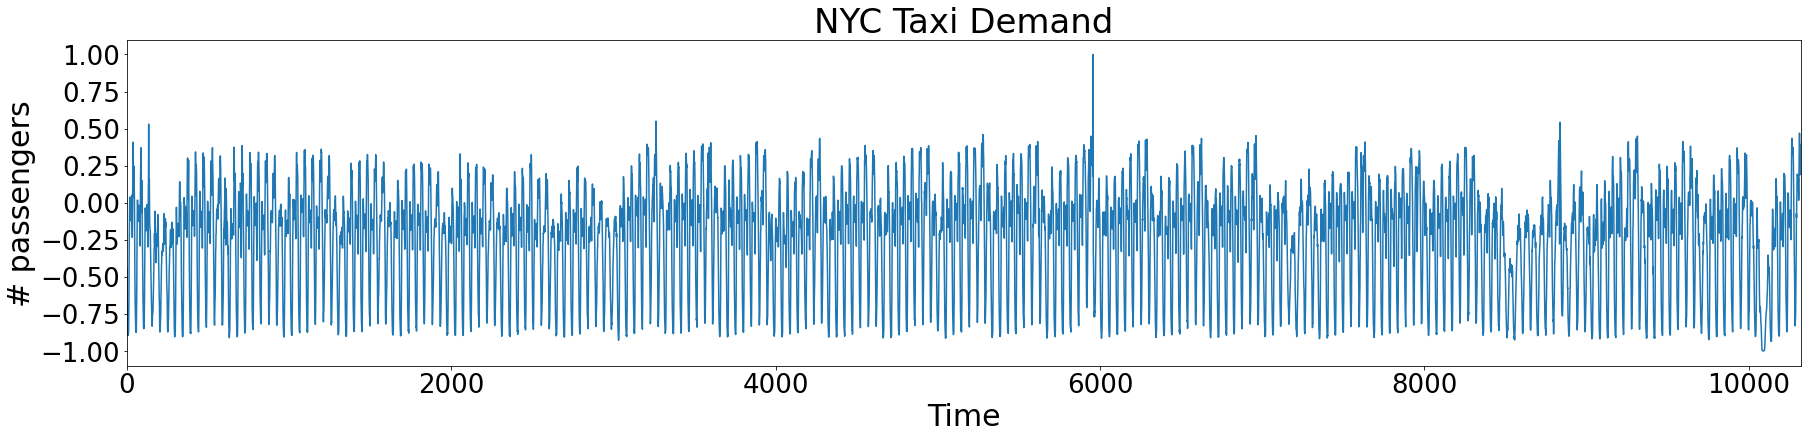

In [10]:
plot_ts(X)

#### D. slice the data to rolling window
to prepare the data, we need to transform it into a sequence that is ingestable by the machine learning model. 
We take the signal we're interested in analyzing and we generate training examples. These training examples are mere snapshots of signal at different times.

In order to do that, we adopt the sliding window approach of choosing a window of a pre-specified width and a particular step size. Once that's been decided we divide the signal indo segments, similar to what is depicited in the illustration below.

<img src="images/sliding_window.png" alt="Drawing" style="width: 400px;"/>

We create a `rolling_window_sequence` function that slices the data into parts, each part contains:
- the target value; the value at time t.
- previous observed values, this is determined by the window width.

In [11]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [12]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (10222, 100, 1)
Training data index shape: (10222,)
Training y shape: (10222, 1)
Training y index shape: (10222,)


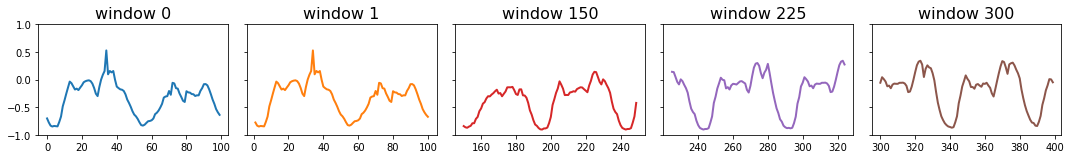

In [13]:
plot_rws(X)

Where `X` represents the input used to train the model. In the previous example, we see `X` has `10222` training data points. Notice that `100` represents the window size. On the other hand, `y` is the real signal after processing, which we will use later on to calculate the error between the reconstructed and real signal. 


### Pipeline Training and Detection

The architecture of the model requires four neural networks:
- `encoder`: maps `X` to its latent representation `Z`.
- `generator`: maps the latent variable `Z` back to `X`, which we will denote later on as `X_hat`.
- `criticX`: discriminates between `X` and `generator(Z)` or `X_hat`.
- `criticZ`: discriminates between `Z` and `encoder(X)`.

we detail the composition of each network in `model.py`.

To use the `TadGAN` model, we specify a number of parameters including the model layers (structure of the previously mentioned neural networks). We also specify the input dimensions, the number of epochs, the learning rate, etc. All the parameters are listed below.

In [14]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 5
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalne

Epoch: 1/5, [Dx loss: [-0.7508938  -3.9765058   2.6382427   0.05873687]] [Dz loss: [-0.8816756  -0.89334834 -1.3032396   0.13149127]] [G loss: [ 1.3264023  -2.6616242   2.3420148   0.16460127]]
Epoch: 2/5, [Dx loss: [-0.7569513  -6.8495493   5.942002    0.01505951]] [Dz loss: [-3.1137466  -1.6358317  -2.802021    0.13241068]] [G loss: [-1.190769   -5.8256965   3.5581317   0.10767957]]
Epoch: 3/5, [Dx loss: [-0.54116493 -5.9626803   5.2729025   0.0148614 ]] [Dz loss: [-1.4693651  -0.98111945 -0.9768529   0.04886079]] [G loss: [-3.0540347  -5.272005    1.3866746   0.08312947]]
Epoch: 4/5, [Dx loss: [-4.7647849e-01 -1.2547022e+01  1.1955168e+01  1.1537253e-02]] [Dz loss: [-1.2444206   0.06033665 -1.8333937   0.05286366]] [G loss: [ -8.893221   -11.918926     2.3783722    0.06473327]]
Epoch: 5/5, [Dx loss: [-4.2078784e-01 -1.3435309e+01  1.2917592e+01  9.6927863e-03]] [Dz loss: [-1.9124205   0.9404395  -3.5262682   0.06734083]] [G loss: [ -7.1260123  -13.004456     4.983489     0.08949511]

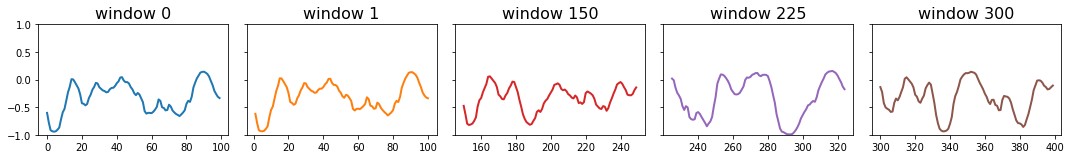

In [15]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

To reassemble or “unroll” the predicted signal `X_hat` we can choose different aggregation methods (e.g., mean, max, etc). In our implementation, we chose it to as the median value.

<img src="images/reconstruct.png" alt="Drawing" style="width: 1000px;"/>

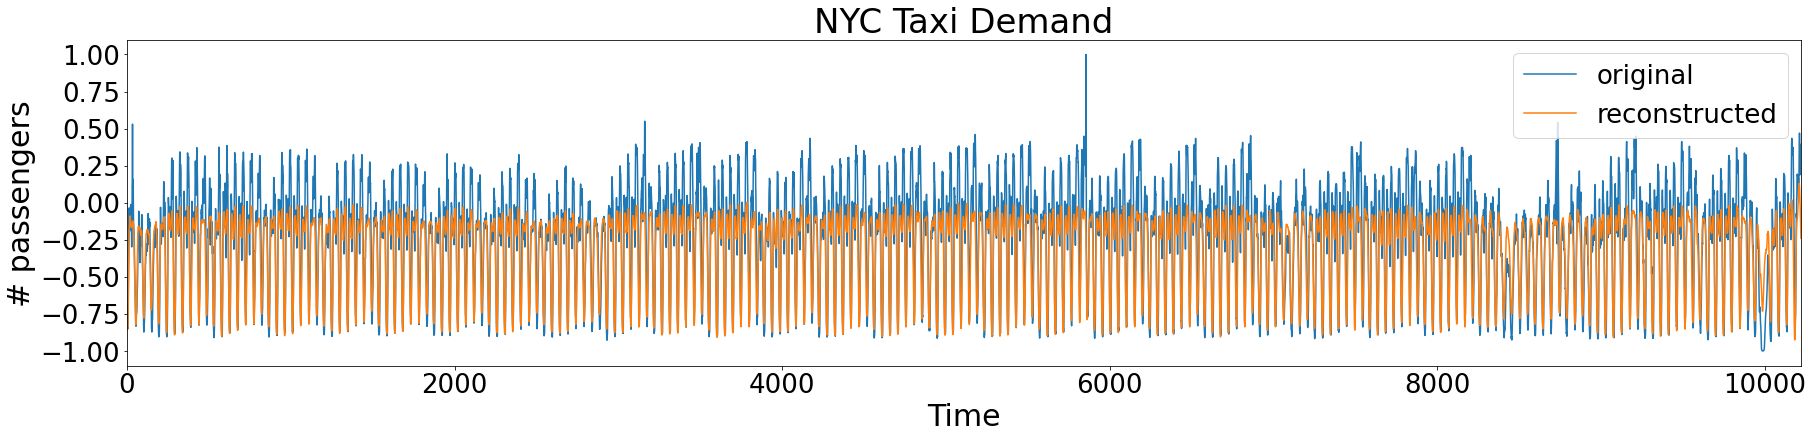

In [16]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

We can see that the GAN model did really well in trying to reconstruct the signal. We also see how it expected the signal to be, in comparison to what it actually is. The discrepancies between the two signals will be used to calculate the error. The higher the error, the more likely it is an anomaly

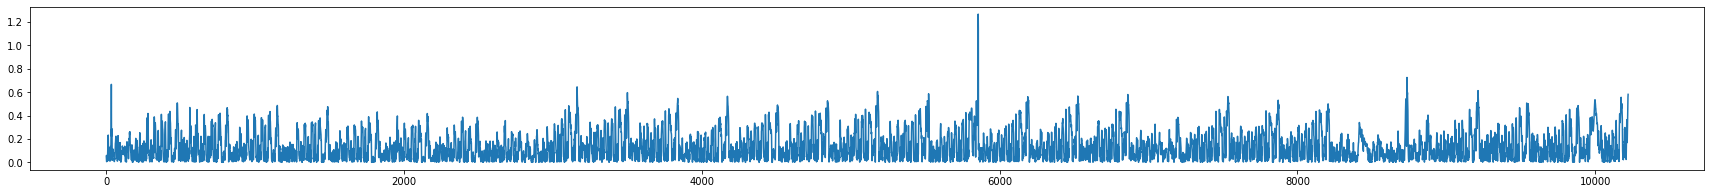

In [17]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

### Error Computation

In the `TadGAN` pipeline, we use `tadgan.score_anomalies` to perform error calculation for us. It is a smoothed error function that uses a window based method to smooth the curve then uses either: area, point difference, or dtw as a measure of discrepancy. 

#### Area
This method captures the general shape of the orignal and reconstructed signal and then compares them together. 

<img src="images/area.png" alt="Drawing" style="width: 300px;"/>

#### Point
This method applies a point-to-point comparison between the original and reconstructed signal. It is considered a strict approach that does not allow for many mistakes.

<img src="images/point.png" alt="Drawing" style="width: 180px;"/>

#### DTW
A more lenient method yet very effective is Dynamic Time Warping (DTW). It compares two signals together using any pair-wise distance measure but it allows for one signal to be lagging behind another.

<img src="images/dtw.png" alt="Drawing" style="width: 400px;"/>

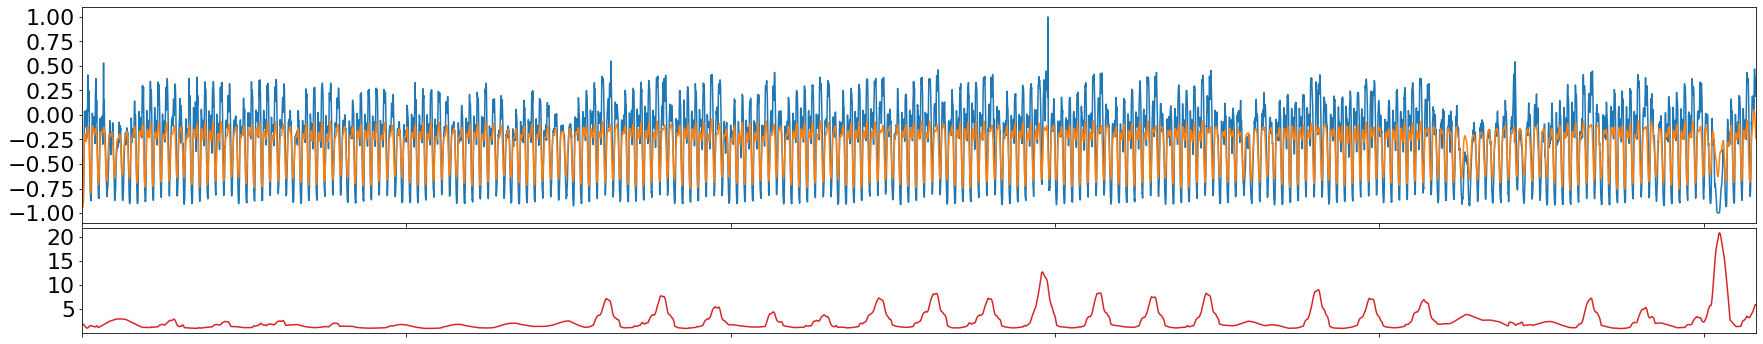

In [18]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

Now we can visually see where the error reaches a substantially high value. But how should we decide if the error value determines a potential anomaly? We could use a fixed threshold that says if `error > 10` then let’s classify the datapoint as anomalous. 

In [19]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while i < len(error) and error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[(1414798200, 1414886400, 11.660054576588122),
 (1422268200, 1422423000, 16.57291621508698)]

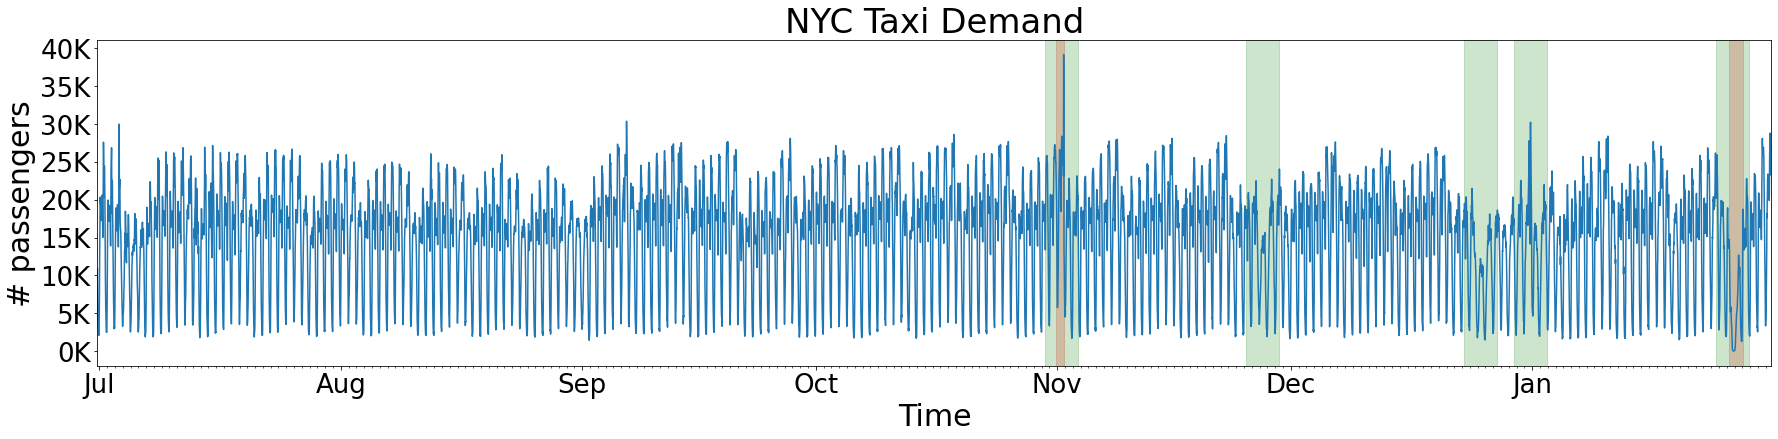

In [20]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

While a fixed threshold raised some correct anomalies, it missed out on others. If we were to look back at the error plot, we notice that some deviations are abnormal within its local region. So how can we incorporate this information in our thresholding technique? We can use window based methods to detect anomalies with respect to their context.

We first define the window of errors, that we want to analyze. We then find the anomalous
sequences in that window by looking at the mean and standard deviation of the errors in the window.
We store the start/stop index pairs that correspond to each sequence, along with its score. 
We then move the window and repeat the procedure.
Lastly, we combine overlapping or consecutive sequences.

In [21]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

array([[1.40985720e+09, 1.41013620e+09, 2.95214751e-01],
       [1.41047460e+09, 1.41073740e+09, 3.14853124e-01],
       [1.41471720e+09, 1.41496020e+09, 1.50102267e-01],
       [1.42219620e+09, 1.42248780e+09, 1.06991651e+00]])

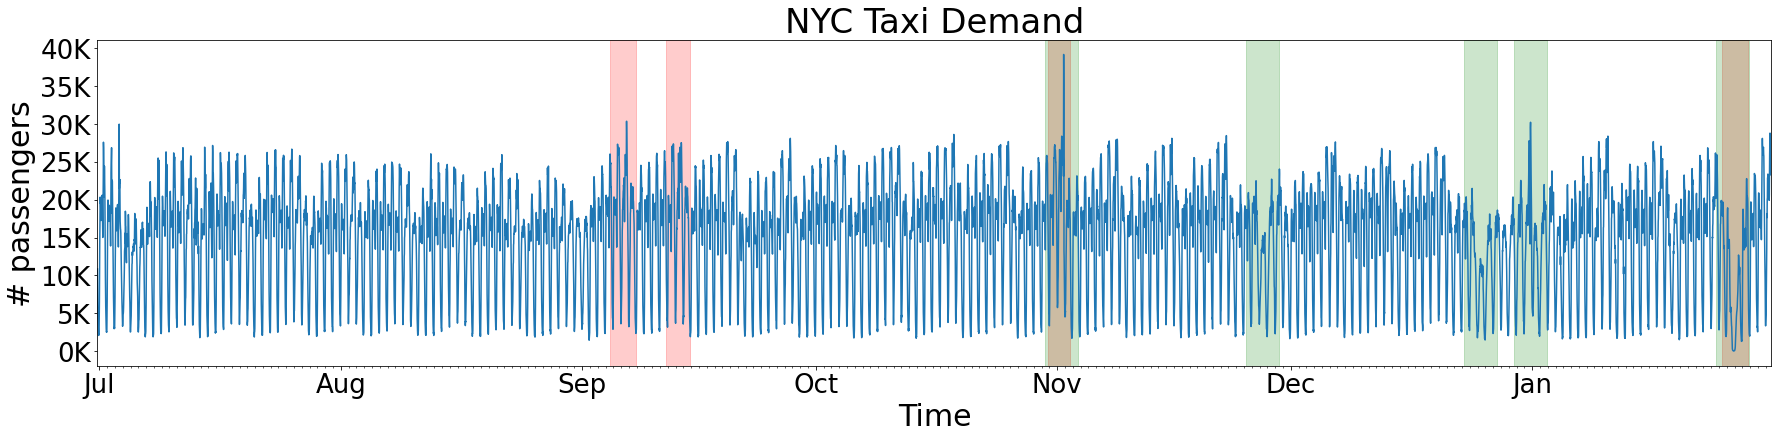

In [22]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

Cool! We now have the same result as we saw previously. The red intervals depict the detected anomalies, the green intervals show the ground truth. We also see that it detected some other intervals that were not included in the ground truth labels.

Using the Orion API and pipelines, we simplified this process yet allowed flexibility for pipeline configuration.

---

### End-to-End Pipeline Configuration

To configure a pipeline, we adjust the parameters of the primitive of interest within the `pipeline.json` file or directly by passing the dictionary to the API.

In the following example, I changed the aggregation level as well as the number of `epochs` for training. These changes will override the parameters specified in the `.json` file. To know more about the API usage and primitive designs, please refer to the [documentation](https://signals-dev.github.io/Orion).

In [23]:
from orion import Orion

parameters = {
    "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1": {
            "interval": 3600 # hour level
        },
    'orion.primitives.tadgan.TadGAN#1': {
        'epochs': 5,
        }
}

orion = Orion(
    'tadgan.json',
    parameters
)

anomalies = orion.fit_detect(df)

/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalne

Epoch: 1/5, [Dx loss: [-0.42925146 -2.5299613   0.76234823  0.13383618]] [Dz loss: [ 5.048744   -0.39353052  4.3442845   0.10979879]] [G loss: [-0.8137807  -0.7692548  -2.1256926   0.20811667]]
Epoch: 2/5, [Dx loss: [-2.8116503  -4.346857    1.2209631   0.03142435]] [Dz loss: [-18.031006    -0.28686535 -19.783342     0.20392041]] [G loss: [26.901857   -1.2315679  26.480808    0.16526121]]
Epoch: 3/5, [Dx loss: [-2.6033845  -4.6942673   1.7504606   0.03404225]] [Dz loss: [ 9.155237   -0.1652547   8.2420845   0.10784084]] [G loss: [-8.0165     -1.7357119  -7.852317    0.15715274]]
Epoch: 4/5, [Dx loss: [-2.1934214  -3.2319632   0.74157685  0.02969639]] [Dz loss: [-33.131268    -0.17601074 -35.33402      0.23787732]] [G loss: [46.1632     -0.728316   45.363506    0.15280072]]
Epoch: 5/5, [Dx loss: [-1.5837581  -1.2709471  -0.53859943  0.02257883]] [Dz loss: [-10.268787     0.16384012 -14.903539     0.44709116]] [G loss: [23.702477    0.6771623  21.39295     0.16323635]]


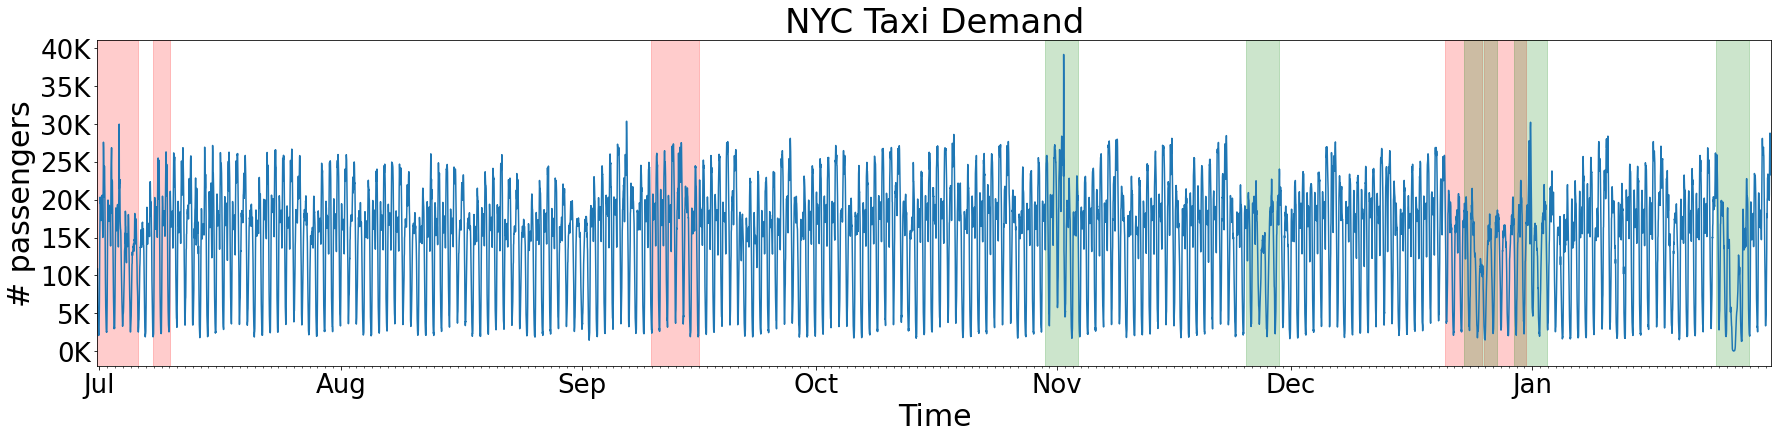

In [24]:
plot(df, [anomalies, known_anomalies])

The anomalies detected in this run are a bit different from the earlier example. Although, it still succeeded in detecting anomalies. Maybe a 1 hour aggregate is not the appropriate value? Maybe we did not train the model enough times, or maybe too many times... How can we tell? One way is to look at the result of the model like we have done previously.

You can use the `visualization` parameter within `detect` to return intermediate outputs (primitive outputs) that we are interested in. For example in the `tadgan.json` file, use `visualization` to return the following variables:

- `X`: this is the output of the preprocessing steps from averaging, imputing, and scaling. These steps were showcased previously as steps (A, B, and C).
- `X_hat`: this is the "predicted" output by the __TadGAN__ model without any processing. It represents the reconstructed window at each timepoint.
- `es`: this is the error calculated by capturing the discrepancies between original and reconstructed signal.

then we use `anomalies, viz = orion.detect(df, visualization=True)` where `viz` will be a dictionary of intermediate outputs.

**Note**: we will talk more about how to evaluate the detected anommalies with respect to the ground truth in part 3 of the tutorial.

---

## Part 3

In part three of the series, we look at evaluation and end-to-end anomaly detection evaluation. 

### Evaluation

We compare the anomalies given to us as ground truth labels to the detected anomalies. But first, we look at some of the mechanisms we have for evaluation, namely:
* **weighted segment**: Assessing every datapoint in the detected anomalies with its counterpart in the ground truth.
* **overlap segment**: Assesses the detected anomaly segment by seeing if we caught an overlap with the correct anomalies.

We will look at both approaches, but first let's construct a dummy dataset.

<img src="images/truth_predicted.jpg" alt="Drawing" style="width: 600px;"/>

Let's assume that the signal starts at timestamp 1, and ends at timestamp 20. We can then see that the ground truth contains three anomalies, namely `(5, 8)`, `(12, 13)`, and `(17, 18)`, where `(i, j)` expresses the starting timestamp `i` and ending timestamp `j`.

We can also see that, we detected two anomalies, namely `(5, 8)` and `(12, 15)`. So how can we compare both sets?

In [25]:
import numpy as np

# to reproduce the same dummy signal
np.random.seed(0)

# dummy data
start, end = (1, 20)
signal = np.random.rand(end - start, 1)

ground_truth = [
    (5, 8),
    (12, 13),
    (17, 18)
]

anomalies = [
    (5, 8),
    (12, 15)
]

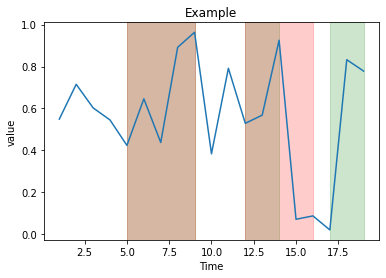

In [26]:
import matplotlib.pyplot as plt

time = range(start, end)
plt.plot(time, signal)

# ground truth
for i, (t1, t2) in enumerate(ground_truth):
    plt.axvspan(t1, t2+1, color="g", alpha=0.2, label="ground_truth")

# detected
for i, (t1, t2) in enumerate(anomalies):
    plt.axvspan(t1, t2+1, color="r", alpha=0.2, label="detected")

    
plt.title("Example")
plt.xlabel("Time")
plt.ylabel("value")
plt.show()

There are two approaches for comparing anomaly sets, as expressed earlier.

(1) **Weighted Segment**, a stricter method, it is valuable to use when you want to equalize the importance of detecting anomalies, and normal instances. 
* It first segments the signal into partitions based on the ground truth and detected sequences. 
* Then it makes a segment to segment comparison and records TP/FP/FN/TN accordingly. 
* The overall score is weighted by the duration (size) of each segment. 

Visually, this operation is summarized by the illustration below. 

<img src="images/weighted_segment.jpg" alt="Drawing" style="width: 700px;"/>

we can use `orion.evaluation` subpackage to compute multiple metrics using the weighted segment approach. For example to compute the accuracy, we use `contextual_accuracy(..., weighted=True)`. There are other metrics available, for reference checkout the `orion.evaluation` documentation.

In [27]:
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score

accuracy = contextual_accuracy(ground_truth, anomalies, start=start, end=end)
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end)

print("Accuracy score = {:0.3f}".format(accuracy))
print("F1 score = {:0.3f}".format(f1_score))

Accuracy score = 0.789
F1 score = 0.750


(2) **Overlap Segment**, a more lenient approach of evaluation. It takes the perspective of rewarding the system if it manages to alarm the user of a subset of an anomaly. More particularly, it records:

1) TP, if a ground truth segment overlaps with the detected segment. 

2) FN, If the ground truth segment does not overlap any detected segments. 

3) FP, If a detected  segment does not overlap any labeled anomalous region. 

This can be summarized by the illustration below.

<img src="images/overlap_segment.jpg" alt="Drawing" style="width: 700px;"/>

Similarly, we can use the same metric functions, but this time we use the parameter `weighted=False`. Note: overlap segment approach, does not account for true negatives. Reason being, anomalies in time series data are rare and so "normal" instances will skew the value of the computed metric. Therefore, using this approach we cannot compute metrics such as the `accuracy`. 

In [28]:
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end, weighted=False)

print("F1 score = {:0.3f}".format(f1_score))

F1 score = 0.800


### Pipeline evaluation end-to-end 

We integrate the evaluation suite into the Orion API, such that you can evaluate the pipeline on a dataset (with its labels) end-to-end. 

Following part 2 introduction to the Orion API, we can create an `orion` instance the use its `evaluate` functionality. We support the method with the following arguments:
* `data`, a `pandas.DataFrame` containing two columns: timestamp and value.
* `truth`, a `pandas.DataFrame` containing two columns: start timestamp and end timestamp of ground truth labels 
* `fit`, a flag denoting whether to train the pipeline before evaluating it.
train_data, a `pandas.DataFrame` containing two columns: timestamp and value used to train the pipeline, if not given, the pipeline will be trained on `data`.
* `metrics`, a list of metrics used to evaluate the pipeline. 

In the previous part we went through how to train a pipeline and use it for anomaly detection, the focus now is on defining `metrics` and evaluating the performance of the pipeline.

`metrics` is list of function names that compares a ground truth labels against detected labels and returns a metric value. We have seen some functions of that sort, such as `contextual_accuracy` and `contextual_f1_score`. To construct our metrics list we select some of the predefined metrics in Orion, such as:
* Accuracy
* F1 Score
* Precision
* Recall

By default, we use the `weighted segment` approach, you can override metrics defined by specifying aa new `metrics` dictitonary.

In [29]:
from orion import Orion
from orion.data import load_signal, load_anomalies
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision

metrics = [
    'f1',
    'recall',
    'precision',
]

orion = Orion(
    'tadgan.json'
)

signal = 'nyc_taxi'

# load signal
df = load_signal(signal)

# load ground truth anomalies
ground_truth = load_anomalies(signal)

scores = orion.evaluate(df, ground_truth, fit=True, metrics=metrics)

/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarahalne

Epoch: 1/5, [Dx loss: [-0.7082181  -3.7187862   2.2515368   0.07590322]] [Dz loss: [ 0.6669892  -0.5304246   0.12389959  0.10735145]] [G loss: [-0.46519816 -2.231383    0.3108502   0.14553346]]
Epoch: 2/5, [Dx loss: [-0.85472286 -4.179546    3.1610613   0.01637634]] [Dz loss: [ 0.9796489   0.3204519  -0.6084076   0.12676051]] [G loss: [ 2.3335476  -3.0568063   3.3695009   0.20208512]]
Epoch: 3/5, [Dx loss: [-0.60799617 -5.9242635   5.1758842   0.0140384 ]] [Dz loss: [ -7.697674     0.80620766 -10.023467     0.1519585 ]] [G loss: [12.140175   -5.2054667  15.719943    0.16257003]]
Epoch: 4/5, [Dx loss: [-0.45911422 -7.8228498   7.244395    0.01193382]] [Dz loss: [-1.9677453   1.434128   -5.534894    0.21330205]] [G loss: [ 0.04487078 -7.066219    6.0035543   0.11075351]]
Epoch: 5/5, [Dx loss: [-0.65835625 -4.078356    3.2847824   0.01352174]] [Dz loss: [ 1.568818    1.3971834  -0.91533214  0.1086967 ]] [G loss: [-1.8231024  -3.52919     0.9593046   0.07467833]]


In [30]:
scores

f1           0.476877
recall       0.385437
precision    0.625197
dtype: float64